<a href="https://colab.research.google.com/github/fabriciodadosbr/classificacao-emocoes-nlp/blob/main/Analise_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuracao do ambiente

In [53]:
# Modelagem de dados e importacao das bases de dados
import pandas as pd
import numpy as np

# graficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from dateutil.parser import parse

#avisos
import warnings
warnings.filterwarnings('ignore')

#cconfiguracoes
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns' ,100)

plt.rcParams['figure.figsize'] = (12,6)
plt.style.use('seaborn-darkgrid')

#libs
import re #REGEX
import nltk #NLP

In [2]:
#lendo a base de dados
url = 'https://raw.githubusercontent.com/fabriciodadosbr/classificacao-emocoes-nlp/main/Tweets_Mg.csv'

In [3]:
base_dados = pd.read_csv(url)

In [4]:
base_dados.shape

(8199, 26)

# Modelagem de dados e Exploracao de dados

### Tratando campos nulos

In [5]:
# campos nulos
nulos = base_dados.isnull()

<Axes: title={'left': 'Analisando os campos nulos'}>

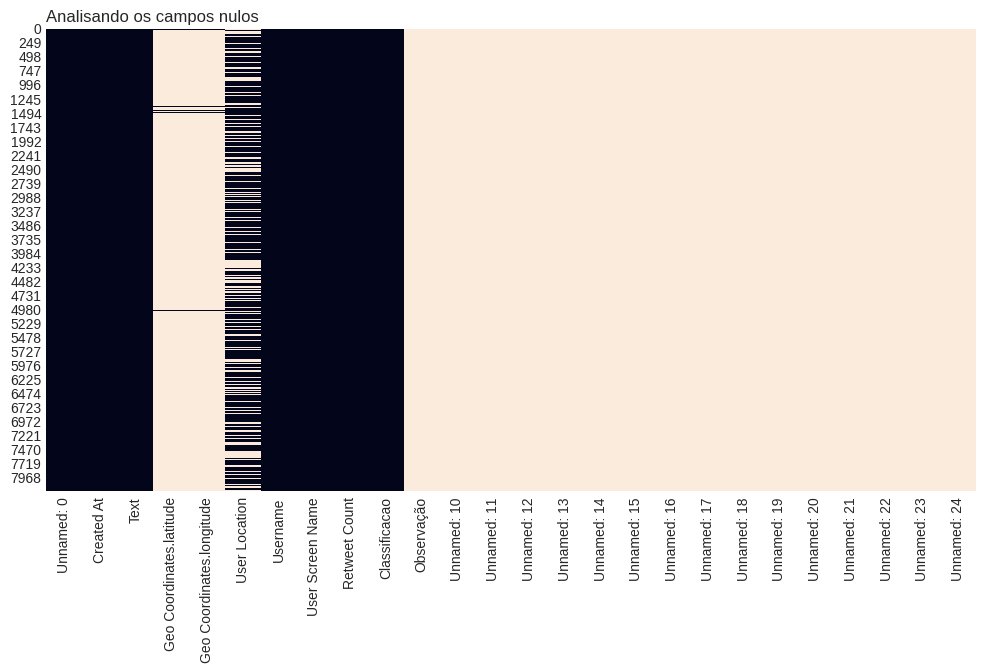

In [6]:
# O que tiver em amarelo está nulos e o que estiver em preto é porque possui dados
plt.title('Analisando os campos nulos', loc='left')
sns.heatmap(nulos,cbar=False)

In [7]:
# extrair colunas desnecessárias para a análise
colunas_extrair = base_dados.columns[10:]
base_dados.drop(columns=colunas_extrair, inplace=True)
base_dados.drop(columns='Unnamed: 0',inplace= True)

In [8]:
base_dados.nunique()

Created At                   7945
Text                         5765
Geo Coordinates.latitude       57
Geo Coordinates.longitude      57
User Location                1591
Username                     3907
User Screen Name             3966
Retweet Count                 113
Classificacao                   3
dtype: int64

In [9]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Created At                 8199 non-null   object 
 1   Text                       8199 non-null   object 
 2   Geo Coordinates.latitude   104 non-null    float64
 3   Geo Coordinates.longitude  104 non-null    float64
 4   User Location              5489 non-null   object 
 5   Username                   8199 non-null   object 
 6   User Screen Name           8199 non-null   object 
 7   Retweet Count              8199 non-null   int64  
 8   Classificacao              8199 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 576.6+ KB


### Ajustando data

In [10]:
# Exemplo de outra forma
base_dados['Data_Formatada'] = base_dados['Created At'].apply( lambda Texto : parse(Texto).date() )

In [11]:
# Gerando Meses,Ano,Dias

# transforma data
base_dados['Data_Formatada'] = pd.to_datetime( base_dados['Data_Formatada'] )

# Extraindo
base_dados['Ano'] = base_dados['Data_Formatada'].dt.year
base_dados['Mes'] = base_dados['Data_Formatada'].dt.month
base_dados['Dia'] = base_dados['Data_Formatada'].dt.day

base_dados.iloc[0:5, 5:]

,Username,User Screen Name,Retweet Count,Classificacao,Data_Formatada,Ano,Mes,Dia
0,Leonardo C Schneider,LeoCSchneider,0,Neutro,2017-01-08,2017,1,8
1,Wândell,klefnews,0,Neutro,2017-01-08,2017,1,8
2,Wândell,klefnews,0,Neutro,2017-01-08,2017,1,8
3,Ana estudando,estudandoconcur,0,Neutro,2017-01-04,2017,1,4
4,Emily,Milly777,0,Negativo,2017-01-09,2017,1,9


In [12]:
#Analisando
base_dados.groupby(by=['Ano','Mes']).agg(
    Quantidade = ('Username','count')
)

Quantidade
Ano  Mes            
2016 12            3
2017 1          7073
     2          1123

### Ajustando geolocalizacao

In [13]:
base_dados.isnull().sum()

Created At                      0
Text                            0
Geo Coordinates.latitude     8095
Geo Coordinates.longitude    8095
User Location                2710
Username                        0
User Screen Name                0
Retweet Count                   0
Classificacao                   0
Data_Formatada                  0
Ano                             0
Mes                             0
Dia                             0
dtype: int64

In [14]:
#filtrando dados nulos
analise_geo = base_dados.loc[
    (base_dados['Geo Coordinates.latitude'].notnull())&
    (base_dados['Geo Coordinates.longitude'].notnull())
]

#analisando o tamanho
analise_geo.shape


(104, 13)

In [15]:
# Agrupar as Geo
analise_localizacao = analise_geo.groupby( by=['Geo Coordinates.latitude', 'Geo Coordinates.longitude'] ).count()[['Username']].reset_index()

# Renomeando colunas
analise_localizacao.columns = ['Lat', 'Lon', 'Quantidade']

In [16]:
# plot dos dados
px.density_mapbox(
    analise_localizacao,
    lat = 'Lat',
    lon = 'Lon',
    z = 'Quantidade',
    mapbox_style = 'stamen-terrain',
    center = dict(lat = -23.700,lon=-46.555),
    zoom = 3
)

In [17]:
base_dados['User Location']

0                              Brasil
1                                 NaN
2                                 NaN
3                                 NaN
4                                 NaN
                    ...              
8194                              NaN
8195    Belo Horizonte - Minas Gerais
8196                   Guarulhos - SP
8197                  Brasil Natal/RN
8198              Belo Horizonte - MG
Name: User Location, Length: 8199, dtype: object

In [18]:
# instalando o geopy
!pip install geopy

In [19]:
#funcao
from geopy.geocoders import Nominatim

instanciando_funcao = Nominatim(user_agent = 'Geoloc')

In [20]:
instanciando_funcao.geocode('Brasil').address


'Brasil'

In [21]:
#analise de representatividade
analise_local = base_dados['User Location'].value_counts(normalize = True).cumsum().reset_index()

analise_local = analise_local.loc[analise_local['User Location'] < 0.5]

analise_local.columns = ['Local','pct']

analise_local.head()


,Local,pct
0,Brasil,0.107670
1,Minas Gerais,0.172163
2,Belo Horizonte - Minas Gerais,0.214793
3,"Belo Horizonte, Brasil",0.256149
4,Belo Horizonte,0.280015


In [22]:
#calcular a quantidade
quantidade = base_dados['User Location'].value_counts().reset_index()

quantidade.columns = ['Local', 'Quantidade']


In [23]:
#merge
tab_localizacao = pd.merge(analise_local,quantidade, on = ['Local'],how ='inner')

In [24]:
#incluindo a geolocalizacao com o GEOPY

tab_localizacao['Latitude'] = None
tab_localizacao['Longitude'] = None

#loop

for loop in range(0,len(tab_localizacao['Local'])):
  try:
    local = instanciando_funcao.geocode(tab_localizacao['Local'][loop])
  except:
    pass
  if local != None:
    tab_localizacao['Latitude'][loop] = local.latitude
    tab_localizacao['Longitude'][loop] = local.longitude
  # print(loop)


In [25]:
tab_localizacao.head()

,Local,pct,Quantidade,Latitude,Longitude
0,Brasil,0.107670,591,-10.333333,-53.2
1,Minas Gerais,0.172163,354,-18.526484,-44.158865
2,Belo Horizonte - Minas Gerais,0.214793,234,-19.922578,-43.945136
3,"Belo Horizonte, Brasil",0.256149,227,-19.922578,-43.945136
4,Belo Horizonte,0.280015,131,-19.922578,-43.945136


In [26]:
# plot dos dados
px.density_mapbox(
    tab_localizacao,
    lat = 'Latitude',
    lon = 'Longitude',
    z = 'Quantidade',
    mapbox_style = 'open-street-map',
    center = dict(lat = -23.700,lon=-46.555),
    zoom = 3
)

### Analisando outras variáveis, Quantidade de palavras

In [27]:
#Usuarios
base_dados['Username'].value_counts()

POLÍCIA MILITAR MG      297
Daniel Araujo #beta     124
Hugo TIMBETA            100
Camila Maciel Serrão     91
Raynniere Makepeace      77
                       ... 
Russo Guedes              1
LUCIANO-LUMOTOKA          1
Hilton Vilar              1
tina thom                 1
Pornografia Destrói       1
Name: Username, Length: 3907, dtype: int64

In [28]:
#Usuarios
base_dados['User Screen Name'].value_counts()

pmmg190            297
danaraujjobeta     124
Hugotim1           100
CamilaMacielSer     91
itsRaynniere        77
                  ... 
gcvascon             1
ClaudioHirakawa      1
SeleneSCW            1
MarcusMartinho       1
porndestroi          1
Name: User Screen Name, Length: 3966, dtype: int64

In [29]:
#Usuarios
base_dados['Retweet Count'].value_counts(normalize = True).head()

0      0.549091
1      0.072692
2      0.037444
444    0.036590
3      0.021100
Name: Retweet Count, dtype: float64

### Análise da Classificaçao


In [30]:
base_dados['Classificacao'].unique()

array(['Neutro', 'Negativo', 'Positivo'], dtype=object)

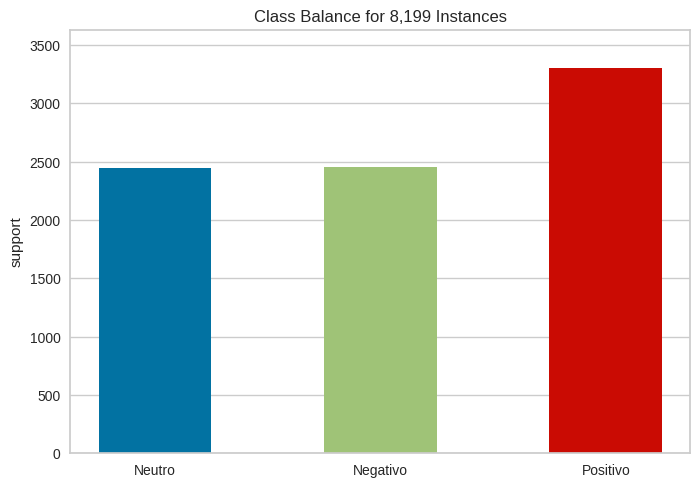

<Axes: title={'center': 'Class Balance for 8,199 Instances'}, ylabel='support'>

In [31]:
#!pip install yellowbrick
# Yellowbrick
from yellowbrick import ClassBalance

grafico_balanco = ClassBalance(labels =['Neutro','Negativo','Positivo'])
grafico_balanco.fit(base_dados['Classificacao'])
grafico_balanco.show()

In [32]:
# plot - Avaliar
analise_valores = base_dados['Classificacao'].value_counts()

#plotly

grafico_balanco_2 = go.Figure(
    go.Funnelarea(
        text = analise_valores.index,
        values = analise_valores.values,
        title = {'text': 'Distribuição dos Sentimentos','position':'top center' }
    )
)

grafico_balanco_2.show()

In [33]:
#quantidade de palavras
#funcao

def qtd_palavras(texto):
  quebrar = texto.split()
  quantidade = len(quebrar)
  return quantidade

base_dados['Quantidade_Palavras'] = base_dados['Text'].apply(qtd_palavras)

base_dados.head()

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Data_Formatada,Ano,Mes,Dia,Quantidade_Palavras
0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,2017-01-08,2017,1,8,10
1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,2017-01-08,2017,1,8,7
2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,2017-01-08,2017,1,8,7
3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,2017-01-04,2017,1,4,2
4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,2017-01-09,2017,1,9,20


In [34]:
# Analise
base_dados['Quantidade_Palavras'].describe()

count    8199.000000
mean       16.141115
std         4.280192
min         1.000000
25%        13.000000
50%        15.000000
75%        19.000000
max        32.000000
Name: Quantidade_Palavras, dtype: float64

In [35]:
#plot

px.box(base_dados, x ='Classificacao',y = 'Quantidade_Palavras',color = 'Classificacao',title  = 'Quantidade de palavras por sentimentos')

### Nuvem de palavras

In [36]:
!pip install wordcloud
#Funcao para nuvem de palavras

from wordcloud import WordCloud

In [37]:
#criando uma wordcloud
#1 etapa concatenar um texto em uma unica string

concatenar = ''

for loop in base_dados['Text']:
  for palavra in loop.split():
    concatenar = concatenar + ' ' + palavra

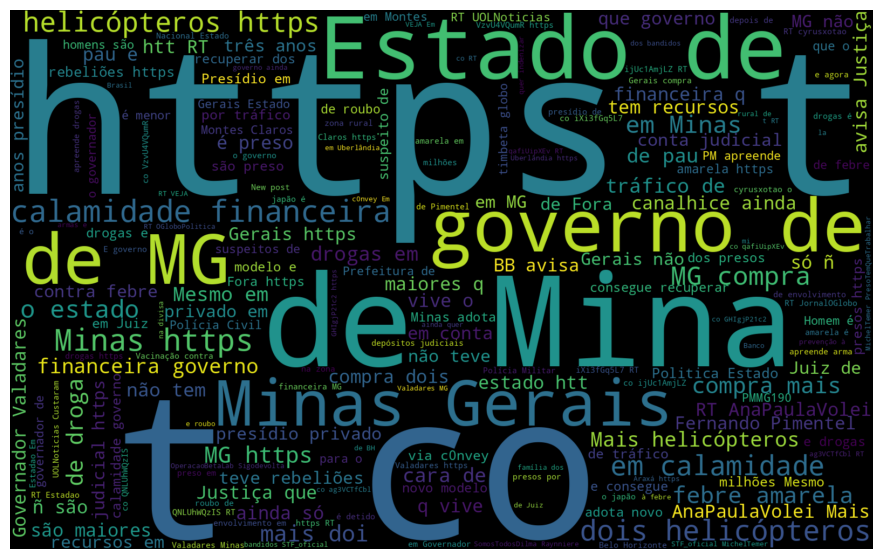

In [38]:
# plot
#2 etapa

nuvem_palavras = WordCloud(width =1600,height =1000).generate(concatenar)

#tamanho
figura,eixo = plt.subplots(figsize = (15,7))
eixo.imshow(nuvem_palavras, interpolation = 'bilinear')
eixo.set_axis_off()

In [39]:
base_dados['Classificacao'].unique()

array(['Neutro', 'Negativo', 'Positivo'], dtype=object)

In [40]:
palavras_positivas = ''
palavras_negativas = ''
palavras_neutras =  ''

for sentimento in base_dados['Classificacao'].unique():
    if sentimento == 'Positivo':
        filtro = base_dados.loc[base_dados['Classificacao'] == sentimento]
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                palavras_positivas = palavras_positivas + ' ' + quebra

    elif sentimento == 'Negativo':
        filtro = base_dados.loc[base_dados['Classificacao'] == sentimento]
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                palavras_negativas = palavras_negativas + ' ' + quebra

    else:
        filtro = base_dados.loc[base_dados['Classificacao'] == sentimento]
        for palavra in filtro['Text']:
            for quebra in palavra.split():
                palavras_neutras = palavras_neutras + ' ' + quebra

print('Quantidade de palavras: \n',
      f'Positivo: {len(palavras_positivas)}',
      f'Negativo: {len(palavras_negativas)}',
      f'Neutro: {len(palavras_neutras)}')


Quantidade de palavras: 
 Positivo: 374456 Negativo: 307576 Neutro: 279383


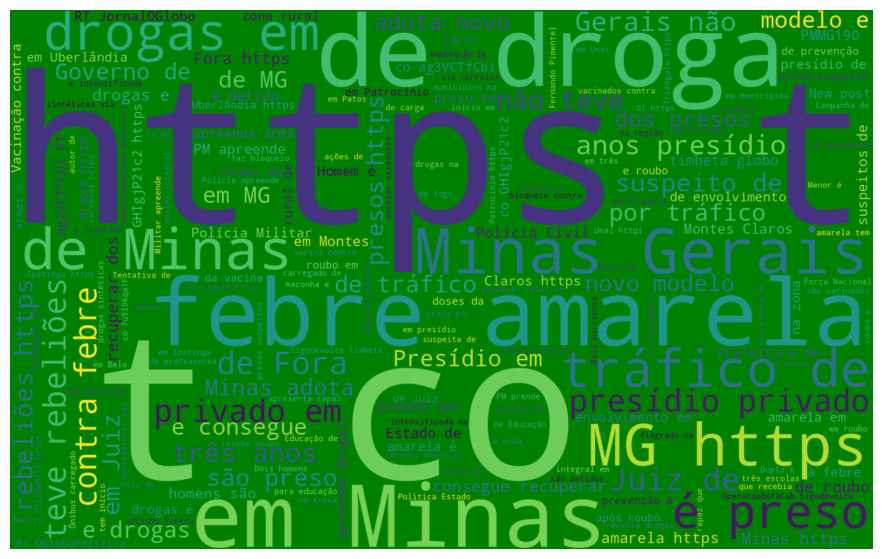

In [41]:
# plot
#2 etapa

nuvem_palavras = WordCloud(width =1600,height =1000,background_color='green').generate(palavras_positivas)

#tamanho
figura,eixo = plt.subplots(figsize = (15,7))
eixo.imshow(nuvem_palavras, interpolation = 'bilinear')
eixo.set_axis_off()

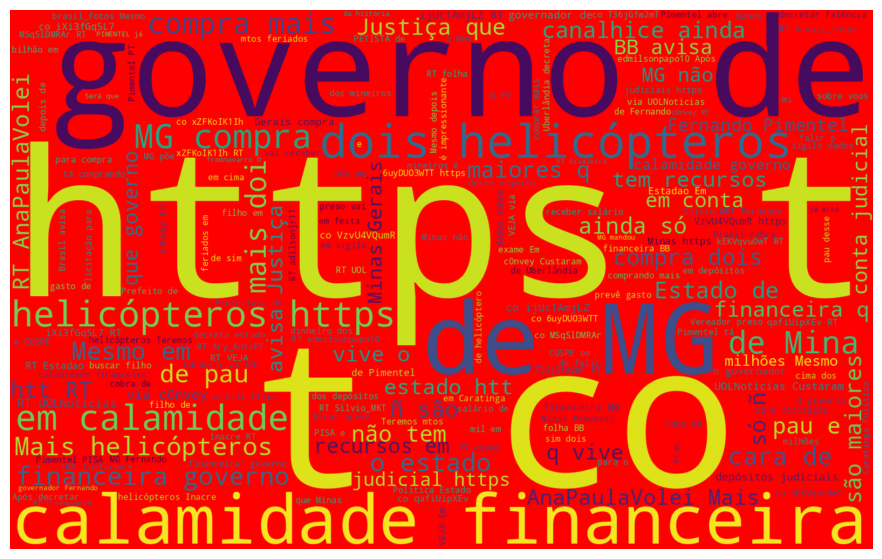

In [42]:
# plot
#2 etapa

nuvem_palavras = WordCloud(width =1600,height =1000,background_color='red').generate(palavras_negativas)

#tamanho
figura,eixo = plt.subplots(figsize = (15,7))
eixo.imshow(nuvem_palavras, interpolation = 'bilinear')
eixo.set_axis_off()

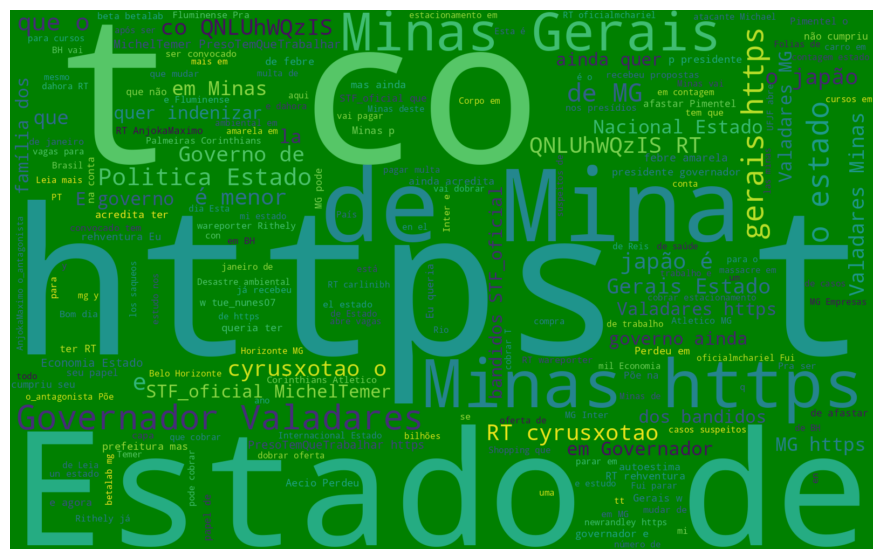

In [43]:
# plot
#2 etapa

nuvem_palavras = WordCloud(width =1600,height =1000,background_color='green').generate(palavras_neutras)

#tamanho
figura,eixo = plt.subplots(figsize = (15,7))
eixo.imshow(nuvem_palavras, interpolation = 'bilinear')
eixo.set_axis_off()

### Rank das palavras mais usadas

In [44]:
# funcao
from collections import Counter #Cria um dicionário contando os ítens

In [60]:
#quebra de frases
quebra_frases = base_dados['Text'].apply( lambda Texto: str(Texto).split())

#Rank das palavras
dados_rank = Counter([item for sublist in quebra_frases for item in sublist])

#tabela
tab_quantidade = pd.DataFrame(dados_rank.most_common(20))

#Ajuste
tab_quantidade.columns = ['Palavra','Qtd']

#verificando
tab_quantidade

,Palavra,Qtd
0,de,8352
1,em,4003
2,RT,3080
3,Minas,2626
4,e,2079
5,-,1937
6,MG,1849
7,a,1707
8,o,1419
9,do,1415


In [61]:
#plot das quantidades
figura = px.bar(
    tab_quantidade,
    x= 'Qtd',
    y = 'Palavra',
    color = 'Palavra',
    orientation = 'h',
    width =700,
    height = 700
)

figura.show()

### Mineração de texto

### Remoção de Duplicados

In [64]:
base_dados.shape

(8199, 14)

In [65]:
base_dados.drop_duplicates(['Text'], inplace = True)

In [66]:
base_dados.shape

(5765, 14)

### Stop Words

In [68]:
# Downloads
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [73]:
#declarando variáveis
pool_palavras = nltk.corpus.stopwords.words('portuguese')

### Radical da Palavra (stemming)

In [74]:
#download
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [80]:
#Função do Radical
radical = nltk.stem.RSLPStemmer()

#lista Palavras
palavras = ['Gostei','Gosto','Gostaram','Gostaria']

for item in palavras:
  print(item, ' - ' , radical.stem(item))

Gostei  -  gost
Gosto  -  gost
Gostaram  -  gost
Gostaria  -  gost


### REGEX